In [98]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## for data
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
import re

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

## Chinese display
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## No warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
df_file = "data/Diarrhea_embed_219.tsv"
df = pd.read_csv(df_file, sep="\t", index_col=0, encoding="utf-8")
df.shape

(11600, 220)

In [4]:
# Stratified sampling
y = "细菌结果"
df_train, df_test = train_test_split(df, test_size=0.3,
                                     stratify=df[y], random_state=42)

# print info
print("X_train shape:", df_train.drop(y, axis=1).shape,
      "| X_test shape:", df_test.drop(y, axis=1).shape)
print("y_train mean:", round(
    np.mean(df_train[y]), 2), "| y_test mean:", round(np.mean(df_test[y]), 2))

print('-'*50)

print("Train set：")
print(df_train[y].value_counts() / len(df_train[y]))
print("Test set：")
print(df_test[y].value_counts() / len(df_test[y]))

X_train shape: (8120, 219) | X_test shape: (3480, 219)
y_train mean: 0.2 | y_test mean: 0.2
--------------------------------------------------
Train set：
0    0.795813
1    0.204187
Name: 细菌结果, dtype: float64
Test set：
0    0.79569
1    0.20431
Name: 细菌结果, dtype: float64


In [5]:
features_raw = df.drop(y, axis=1).columns.to_list()
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

X_train = df_train[features_raw]
y_train = df_train[y]

X_test = df_test[features_raw]
y_test = df_test[y]

In [45]:
f = re.compile(r'(.+)_dim')
feature_list = []
for value in df.columns.tolist():
    temp = "".join(f.findall(value))
    if temp not in feature_list and temp:
        feature_list.append(temp)
numeric = ['age', '体温', '呕吐频次', '持续天数', '腹泻量', '腹泻频次', '腹泻天数', '疑似病例人数']
feature_list = feature_list + numeric
print(feature_list)
len(feature_list)

['区县', '性别', '户籍', '职业', '首发症状', '发热', '脱水', '腹胀', '恶心', '里急后重', '肠鸣音亢进', '腹痛', '腹痛性质', '腹痛部位', '呕吐', '呕吐在腹泻___发生', '腹泻', '腹泻性质', '神经症状', '中毒症状', '其他症状', '近6个月有无肠道疾病既往史', '发病前五天内是否有不洁饮食史', '进餐地点', '发病前5天内是否有不洁饮水史', '发病前5天内周边有无类似腹泻病例', '发病前5天内是否有聚餐史', '发病前一周是否外出', '是否家中饲养或接触过宠物', '就诊前是否服用过抗生素', '诊断', '诊断类型', '临床处理', '本次就诊是否给予抗生素', '抗生素名称.1', '是否采集', '采样类型', 'age', '体温', '呕吐频次', '持续天数', '腹泻量', '腹泻频次', '腹泻天数', '疑似病例人数']


45

In [47]:
def df2array(df):
    """
    df --> array
    """
    df_array = np.zeros((df.shape[0], len(feature_list), 47))
    for i in range(df.shape[0]):
        for j, value in enumerate(feature_list):
            for k in range(47):
                try:
                    df_array[i,j,k] = df.loc[i,value+'_dim'+str(k)]
                except:
                    break
    return df_array

In [ ]:
X_train_array = df2array(X_train)
X_test_array = df2array(X_test)

In [58]:
X_train_array.shape  # (8120, 45, 47)
X_test_array.shape   # (3480, 45, 47)

y_train_array = y_train.values
y_test_array = y_test.values

(8120, 45, 47)

(3480, 45, 47)

In [61]:
## Train set
# converting array into torch format
train_x = X_train_array.reshape(8120, 1, 45, 47)
train_x = torch.from_numpy(train_x)

# converting the target into torch format
train_y = y_train_array.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([8120, 1, 45, 47]), torch.Size([8120]))

In [101]:
## Test set
# converting array into torch format
test_x = X_test_array.reshape(3480, 1, 45, 47)
test_x = torch.from_numpy(test_x)

# converting the target into torch format
test_y = y_test_array.astype(int)
test_y = torch.from_numpy(test_y)

# shape of training data
test_x.shape, test_y.shape

(torch.Size([3480, 1, 45, 47]), torch.Size([3480]))

## CNN model

In [77]:
class GlobalMaxPool1d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool1d, self).__init__()
    def forward(self, x):
        """
        x shape: (batch_size, num_filters, n_out)
        return shape: (batch_size, num_filters, 1)
        """
        return F.max_pool1d(x, kernel_size=x.shape[2])

class CNN(nn.Module):
    def __init__(self, embed_size, num_classes, num_filters=100, 
                 filter_sizes=[2,3,4], hidden_size=128, dropout_rate=0.3):
        super(CNN, self).__init__()
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=1, 
                                              out_channels=num_filters, 
                                              kernel_size=(k, embed_size), 
                                              padding=(k - 1, 0)) for k in filter_sizes])
        self.max_pool = GlobalMaxPool1d()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=True)
        
    def forward(self, x):
        """
        x shape: (batch_size, 1, feature_number, embed_size)
        return shape: (batch_size, num_classes)
        """
        convolution = [conv(x) for conv in self.convs]  # (batch_size, num_filters, n_out, 1) 
        max1 = self.max_pool(convolution[0].squeeze())  # (batch_size, num_filters, 1)
        max2 = self.max_pool(convolution[1].squeeze())
        max3 = self.max_pool(convolution[2].squeeze())
        cat = torch.cat((max1, max2, max3), dim=2)  # （batch_size, num_filters, 1*len(filter_sizes)）  
        x = cat.view(cat.shape[0], -1)  # (batch_size, num_filter * len(filter_sizes))
        x = self.fc1(self.relu(x))  # (batch_size, hidden_size)
        x = self.dropout(x)  # (batch_size, hidden_size)
        outputs = self.fc2(x)  # (batch_size, num_classes) 
        return outputs

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_size = 47
num_classes = 2
num_filters = 100
filter_sizes = [2, 3, 4]
hidden_size = 128
dropout_rate = 0.3
learning_rate = 0.01

In [79]:
model = CNN(embed_size, num_classes, num_filters,
            filter_sizes, hidden_size, dropout_rate)
model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

CNN(
  (convs): ModuleList(
    (0): Conv1d(1, 100, kernel_size=(2, 47), stride=(1,), padding=(1, 0))
    (1): Conv1d(1, 100, kernel_size=(3, 47), stride=(1,), padding=(2, 0))
    (2): Conv1d(1, 100, kernel_size=(4, 47), stride=(1,), padding=(3, 0))
  )
  (max_pool): GlobalMaxPool1d()
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [92]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # converting the data into GPU format
    x_train = x_train.to(device, dtype=torch.float)
    y_train = y_train.to(device, dtype=torch.long)

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training set
    output_train = model(x_train)

    # computing the training loss
    loss_train = criterion(output_train, y_train)
    train_losses.append(loss_train)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%50 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', tr_loss)

In [ ]:
n_epochs = 5000
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model: final_loss is 0.14
for epoch in range(n_epochs):
    train(epoch)

In [102]:
# calculate AUC | F1-Score | Precision | Recall
model.eval()
with torch.no_grad():
    x_test= Variable(test_x)
    x_test = x_test.to(device, dtype=torch.float)
    output_test = model(x_test)

softmax = torch.exp(output_test).cpu()
predicted_prob = list(softmax.numpy())
predicted = np.argmax(predicted_prob, axis=1)

CNN(
  (convs): ModuleList(
    (0): Conv1d(1, 100, kernel_size=(2, 47), stride=(1,), padding=(1, 0))
    (1): Conv1d(1, 100, kernel_size=(3, 47), stride=(1,), padding=(2, 0))
    (2): Conv1d(1, 100, kernel_size=(4, 47), stride=(1,), padding=(3, 0))
  )
  (max_pool): GlobalMaxPool1d()
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [114]:
def eval(y_test, predicted):

    # Accuray e AUC
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted)
    print("Accuracy (overall correct predictions):",  round(accuracy, 2))
    print("Auc:", round(auc, 2))

    # Precision e Recall
    recall = metrics.recall_score(y_test, predicted)
    precision = metrics.precision_score(y_test, predicted)
    print("Recall (all 1s predicted right):", round(recall, 2))
    print("Precision (confidence when predicting a 1):", round(precision, 2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted,
          target_names=[str(i) for i in np.unique(y_test)]))

    # confusion matrix
    classes = np.unique(y_test)
    fig, ax = plt.subplots(figsize=(7, 5))
    cm = metrics.confusion_matrix(y_test, predicted, labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
    ax.set_yticklabels(labels=classes, rotation=0)
    plt.tight_layout()
    plt.show()

    return recall, precision, cm

Accuracy (overall correct predictions): 0.75
Auc: 0.63
Recall (all 1s predicted right): 0.42
Precision (confidence when predicting a 1): 0.39
Detail:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2769
           1       0.39      0.42      0.41       711

    accuracy                           0.75      3480
   macro avg       0.62      0.63      0.62      3480
weighted avg       0.75      0.75      0.75      3480



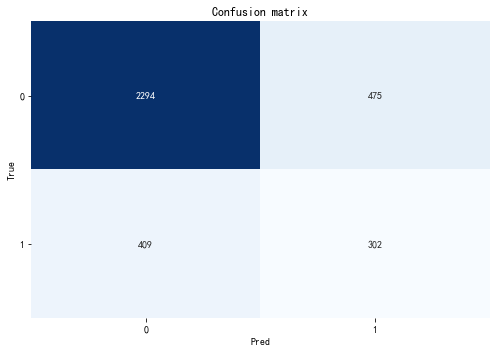

In [115]:
recall, precision, cm = eval(test_y, predicted)